In [11]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import IPython
import tensorflow as tf

import prepare_data
import training
import utils
import models
import gin

gin.parse_config_file('config/experiments/01_naive_reduced.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


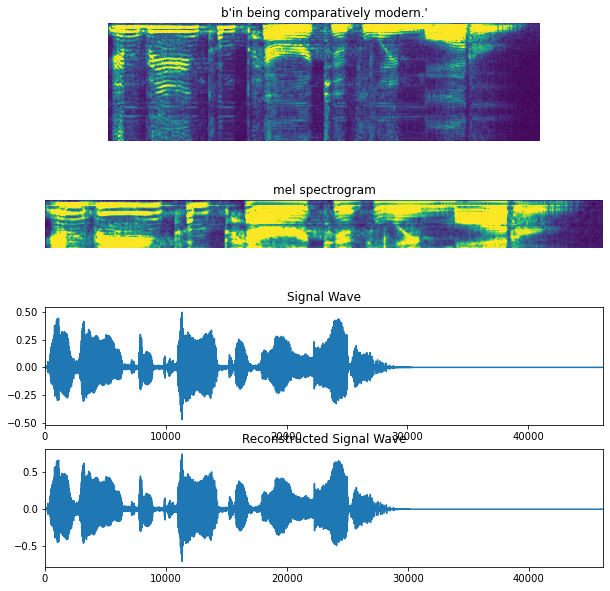

In [12]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

fig = plt.figure(figsize=(10, 10))
for batch in train_dataset.take(1):
    spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    mel_spec = np.array([np.trim_zeros(x) for x in np.transpose(mel_spec)])

    ax = plt.subplot(4, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(transcription)
    ax.axis("off")


    ax = plt.subplot(4, 1, 2)
    ax.imshow(mel_spec, vmax=1)
    ax.set_title('mel spectrogram')
    ax.axis("off")

    ax = plt.subplot(4, 1, 3)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    
    rec_audio = tf.signal.inverse_stft(
        raw_spectrogram,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

    ax = plt.subplot(4, 1, 4)
    plt.plot(rec_audio)
    ax.set_title("Reconstructed Signal Wave")
    ax.set_xlim(0, len(rec_audio))
        

    IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
    IPython.display.display(IPython.display.Audio(np.transpose(rec_audio), rate=sample_rate))

    
    
plt.show()


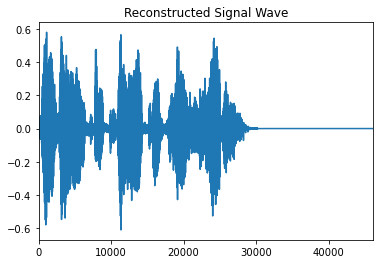

In [13]:
reconstructed_audio = utils.griffin_lim(tf.abs(raw_spectrogram), fft_length, frame_step, 50)

ax = plt.subplot(1, 1, 1)
plt.plot(reconstructed_audio)
ax.set_title("Reconstructed Signal Wave")
ax.set_xlim(0, len(reconstructed_audio))
plt.show()

IPython.display.display(IPython.display.Audio(np.transpose(reconstructed_audio), rate=sample_rate))

In [25]:
naiveLstmTTS = models.NaiveLstmTTS()
naiveLstmTTS.model.set_weights(tf.keras.models.load_model('models/20220517-005202_01_naive_reduced__NaiveLstmTTS').get_weights())

In [26]:
# Extremely slow at the moment

new_mel_spec, new_spec = naiveLstmTTS.decode(tf.expand_dims(enc_transcription, 0), 300) # 3320)

2022-05-17 00:53:18.885687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-17 00:53:18.934144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-17 00:53:19.150734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-17 00:53:19.190734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


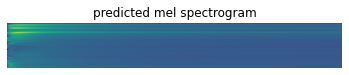

In [27]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(new_mel_spec[0]), vmax=1)
ax.set_title('predicted mel spectrogram')
ax.axis("off")
plt.show()

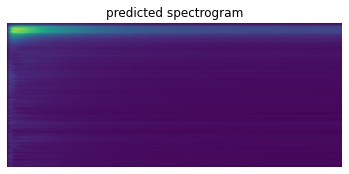

In [28]:
ax = plt.subplot(1, 1, 1)
ax.imshow(np.transpose(new_spec[0]), vmax=1)
ax.set_title('predicted spectrogram')
ax.axis("off")
plt.show()

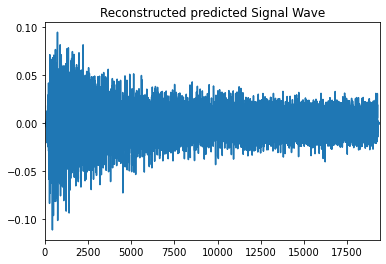

In [29]:
reconstructed_audio = utils.griffin_lim(tf.abs(new_spec[0]), fft_length, frame_step, 50)

ax = plt.subplot(1, 1, 1)
plt.plot(reconstructed_audio)
ax.set_title("Reconstructed predicted Signal Wave")
ax.set_xlim(0, len(reconstructed_audio))
plt.show()

IPython.display.display(IPython.display.Audio(np.transpose(reconstructed_audio), rate=sample_rate))